In [1]:
# Import dependencies
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
#Data preprocessing
#Define the path of the dataset and get the labels for categories
data_path='./dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
#Create the dict with labels and numeric values correspending
label_dict=dict(zip(categories,labels))
print('Dict to use:')
print(label_dict)

Dict to use:
{'ichika': 0, 'itsuki': 1, 'miku': 2, 'nino': 3, 'yotsuba': 4}


In [4]:
#Define the fixed size
img_size=(150, 300)
data=[]
target=[]

In [5]:
#Runs every folder and add every img and label corresponding to folder
for category in tqdm(categories, desc="Processing images"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    
    # Barra de progreso sobre cada imagen
    for img_name in tqdm(img_names, desc=f"Processing images in {category}", leave=False):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        try:
            resized = cv2.resize(img, (img_size[0], img_size[1]))
            data.append(resized)
            target.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Convert lists to arrays
# data=np.array(data)/255.0
data=np.reshape(data,(len(data),img_size[1], img_size[0],3))
target=np.array(target)
target=to_categorical(target)

Processing images: 100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


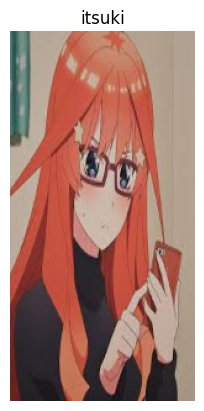

In [26]:
index = np.random.randint(0, len(data))
img_to_show = data[index]
img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)

index_to_label = {v: k for k, v in label_dict.items()}
label_index = np.argmax(target[index])
label_name = index_to_label[label_index]
plt.imshow(img_to_show)
plt.title(f"{label_name}")
plt.axis('off')
plt.show()
#{'ichika': 0, 'itsuki': 1, 'miku': 2, 'nino': 3, 'yotsuba': 4}

In [ ]:
#data augmentation

In [27]:
# Split the dataset into training and validation sets
# stratofy is for save the proportion for each class
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (2932, 300, 150, 3)
Validation data shape: (733, 300, 150, 3)
Training labels shape: (2932, 5)
Validation labels shape: (733, 5)


In [28]:
# Model training
# Load EfficientNetB0  preajusted with imagenet without last layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[1], img_size[0], 3))

base_model.trainable = True
# Freeze all layers except the last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add more layers
model = models.Sequential([
    # layers from EfficientNetB0
    base_model,
    # reduce the data size keeping most important values
    layers.GlobalAveragePooling2D(),
    # delete random 20% of the conecctions
    layers.Dropout(0.2),
    # dense layer with 128 nurons
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    # output layer one for each class and softmax to get probability
    layers.Dense(5, activation='softmax')
])

# Optimizer adam and loss function for classification in base of accuaracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stoping --> if not improve later than 5 epochs restore best weights
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 10, 5, 1280)    │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 1,515,573 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [29]:
# fit the model and save the history
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 748ms/step - accuracy: 0.6601 - loss: 0.8438 - val_accuracy: 0.9113 - val_loss: 0.2988
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 724ms/step - accuracy: 0.9508 - loss: 0.1525 - val_accuracy: 0.8458 - val_loss: 0.7566
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 718ms/step - accuracy: 0.9494 - loss: 0.1450 - val_accuracy: 0.9427 - val_loss: 0.2094
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 723ms/step - accuracy: 0.9800 - loss: 0.0601 - val_accuracy: 0.9386 - val_loss: 0.2456
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 767ms/step - accuracy: 0.9736 - loss: 0.0750 - val_accuracy: 0.9345 - val_loss: 0.2787
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 737ms/step - accuracy: 0.9771 - loss: 0.0784 - val_accuracy: 0.9509 - val_loss: 0.2208
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 727ms/step - accuracy: 0.9824 - loss: 0.0558 - val_accuracy: 0.9318 - val_loss: 0.2773
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 754ms/step - accuracy: 0.9896 - loss: 0.0375 - val_accu

In [ ]:
model.save('models/model.h5')

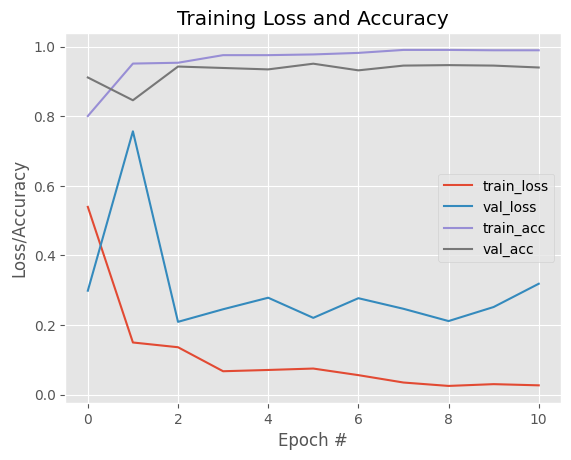

In [31]:
# plot the training loss and accuracy
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [32]:
# Hacer predicciones
predictions = model.predict(X_val)

# Obtener las clases predichas (la clase con la probabilidad más alta)
predicted_classes = np.argmax(predictions, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 612ms/step


In [33]:
def plot_images(images, true_labels, predicted_labels, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {class_names[np.argmax(true_labels[i])]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

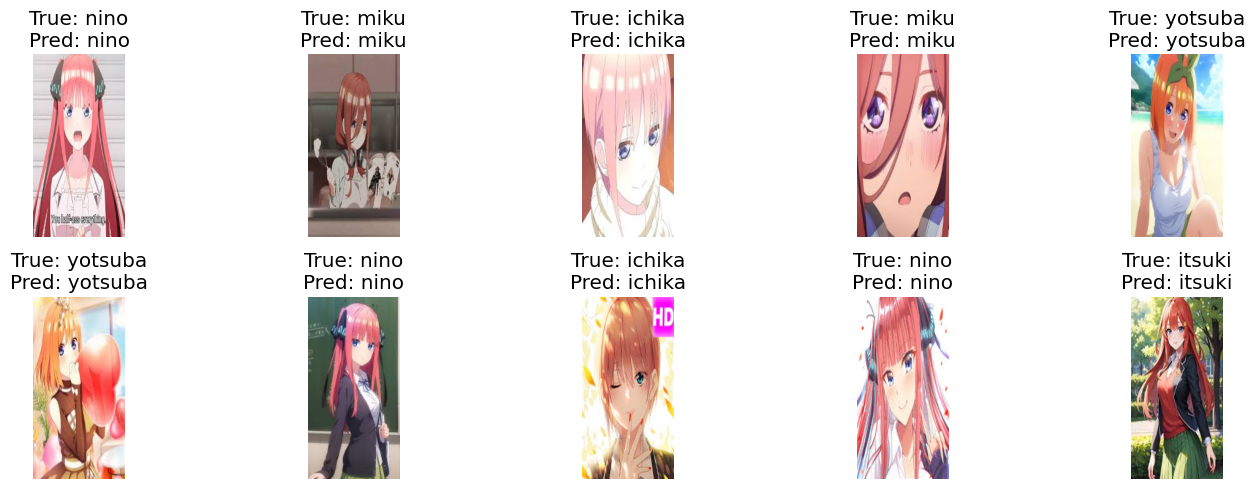

In [34]:
plot_images(X_val, y_val, predicted_classes, categories, num_images=10)

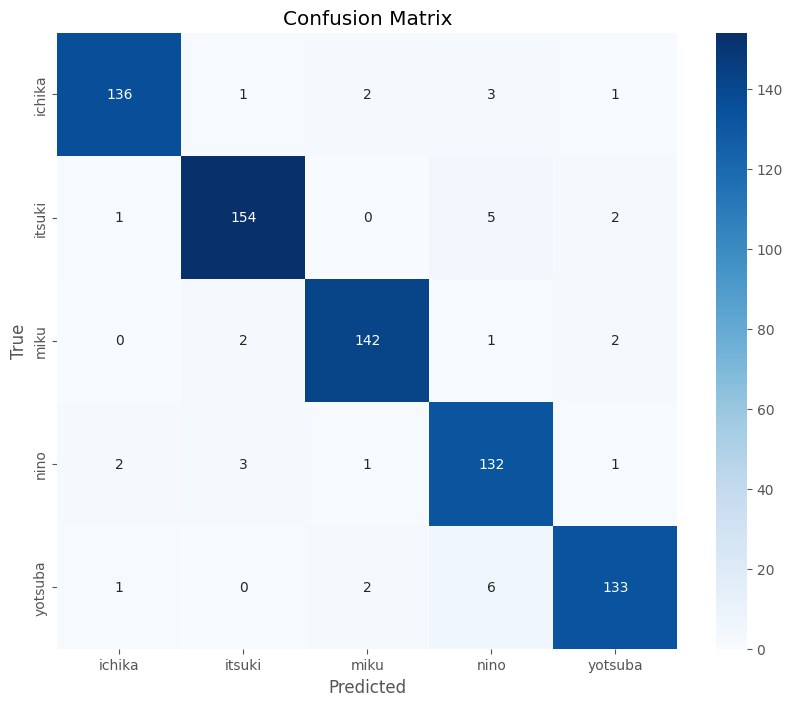

In [35]:
# confusion matrix
true_classes = np.argmax(y_val, axis=1)
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()